In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from glob import glob
import PIL
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample


import PIL
from PIL import Image as pilimg

import cv2

In [2]:
# !pip install captum

In [3]:
metadata = pd.read_csv("./Dataset/HAM10000_metadata.csv")
metadata = metadata[['image_id', 'dx']].rename({'image_id':'imgid' , 'dx' :'class'})

In [4]:
metadata.shape

(10015, 2)

In [5]:
metadata.rename({'image_id': 'image_id', 'dx': 'class'}, axis=1, inplace=True)
metadata.head()

,image_id,class
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl


In [6]:
metadata['class'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: class, dtype: int64

In [7]:
le = LabelEncoder()
metadata['class'] = le.fit_transform(metadata['class'])

In [8]:
df1 = metadata[metadata['class']==0]
df2 = metadata[metadata['class']==1]
df3 = metadata[metadata['class']==2]
df4 = metadata[metadata['class']==3]
df5 = metadata[metadata['class']==4]
df6 = metadata[metadata['class']==5]
df7 = metadata[metadata['class']==6]

In [9]:
samples = 1000
df1_balanced = resample(df1,replace = True,n_samples = samples,random_state = 2)
df2_balanced = resample(df2,replace = True,n_samples = samples,random_state = 2)
df3_balanced = resample(df3,replace = True,n_samples = samples,random_state = 2)
df4_balanced = resample(df4,replace = True,n_samples = samples,random_state = 2)
df5_balanced = resample(df5,replace = True,n_samples = samples,random_state = 2)
df6_balanced = resample(df6,replace = True,n_samples = samples,random_state = 2)
df7_balanced = resample(df7,replace = True,n_samples = samples,random_state = 2)

In [10]:
merged = pd.concat([df1_balanced,df2_balanced,df3_balanced,
                  df4_balanced,df5_balanced,df6_balanced,df7_balanced])

In [11]:
dir = "./Dataset/Skin Cancer/Skin Cancer"
id = [x.split('.')[0] for x in os.listdir(dir)]
image_path = {x:os.path.join(dir,f'{x}.jpg') for x in id}
merged['path'] = merged['image_id'].map(image_path.get)

In [12]:
merged.head(1)

,image_id,class,path
9855,ISIC_0029851,0,./Dataset/Skin Cancer/Skin Cancer\ISIC_0029851...


In [13]:
sample = {}
numpy_horizontal = []
limit = 0
for index, row in merged.iterrows():
    limit +=1
    if limit==10:
        break
    pth =row['path']
    cl = row['class']
    print(pth)
    image = np.asarray(pilimg.open(pth).resize((224,224)))
    
#     print(image.shape)
    if len(numpy_horizontal)==0:
        numpy_horizontal = np.hstack((image, image))
    
    else:
        numpy_horizontal = np.hstack((numpy_horizontal, image))


./Dataset/Skin Cancer/Skin Cancer\ISIC_0029851.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0027795.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0030827.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0030242.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0028517.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0026729.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0028763.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0032356.jpg
./Dataset/Skin Cancer/Skin Cancer\ISIC_0029860.jpg


(100, 1000, 3)


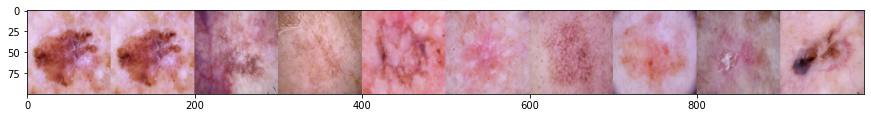

In [14]:
x = cv2.resize(numpy_horizontal,(1000, 100))
print(x.shape)
plt.figure(figsize=(15,8))
plt.imshow(x)

# Resnet18 MODEL (PYTORCH)

In [15]:
import torch
from torchvision import datasets, transforms
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensor

import numpy as np

import torch.nn as nn
import torch.nn.functional as F

In [16]:

class Args:

    # Data Loading
    # ============

    train_batch_size = 64
    val_batch_size = 64
    num_workers = 4

    # Augmentation
    # ============
    horizontal_flip_prob = 0.2
    vertical_flip_prob = 0.0
    gaussian_blur_prob = 0.0
    rotate_degree = 20
    cutout = 0.3

    # Training
    # ========
    random_seed = 1
    epochs = 50
    learning_rate = 0.01
    momentum = 0.9
    lr_step_size = 5
    lr_gamma = 0.15

    # Evaluation
    # ==========
    sample_count = 25




class Transforms:
    

    def __init__(self, train = True,  **transform_args):
        
        
        ## ARGS
        
        horizontal_flip_prob = transform_args['horizontal_flip_prob']
        vertical_flip_prob = transform_args['vertical_flip_prob']
        gaussian_blur_prob = transform_args['gaussian_blur_prob']
        rotate_degree = transform_args['rotate_degree']
        cutout = transform_args['cutout']
        cutout_height = transform_args['cutout_height']
        cutout_width = transform_args['cutout_width'] 
    
        
        mean=(0.5, 0.5, 0.5)
        std=(0.5, 0.5, 0.5)
        
        # Train phase transformations
         
        transforms_list = []
    
        if train:
            if horizontal_flip_prob > 0:  # Horizontal Flip
                transforms_list += [A.HorizontalFlip(p=horizontal_flip_prob)]
            if vertical_flip_prob > 0:  # Vertical Flip
                transforms_list += [A.VerticalFlip(p=vertical_flip_prob)]
            if gaussian_blur_prob > 0:  # Patch Gaussian Augmentation
                transforms_list += [A.GaussianBlur(p=gaussian_blur_prob)]
            if rotate_degree > 0:  # Rotate image
                transforms_list += [A.Rotate(limit=rotate_degree)]
    
            if cutout > 0:  # CutOut
                transforms_list += [A.CoarseDropout(
                    p=cutout, max_holes=1, fill_value=tuple([x * 255.0 for x in mean]),
                    max_height=cutout_height, max_width=cutout_width, min_height=1, min_width=1
                )]
#             pass
                
            transforms_list +=[A.augmentations.transforms.ColorJitter(brightness=(0.01,0.1),contrast=(0.01,0.1),
                                                                      saturation=(0.01,0.1), hue=(-0.15,0.15), always_apply=False, p=0.15)]
    
        transforms_list += [
            # normalize the data with mean and standard deviation to keep values in range [-1, 1]
            # since there are 3 channels for each image,
            # we have to specify mean and std for each channel
            A.Normalize(mean=mean, std=std, always_apply=True),
            
            # convert the data to torch.FloatTensor
            # with values within the range [0.0 ,1.0]
            ToTensor()
        ]
    
    
        self.transform =  A.Compose(transforms_list)    

    def __call__(self, image):
        """Process and image through the data transformation pipeline.

        Args:
            image: Image to process.
        
        Returns:
            Transformed image.
        """

        image = np.array(image)
        image = self.transform(image=image)['image']
        return image


In [17]:
train_met, test_met = train_test_split(merged, test_size = 0.2, shuffle=True)

In [18]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform = None):
        self.df = data
        self.transform = transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        image_path = self.df[['path']].iloc[index].item()
        image = np.asarray(pilimg.open(image_path).resize((64,64)))
        label = self.df[['class']].iloc[index].item()
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [19]:
train_met.head(2)

,image_id,class,path
2851,ISIC_0027425,1,./Dataset/Skin Cancer/Skin Cancer\ISIC_0027425...
1037,ISIC_0031088,2,./Dataset/Skin Cancer/Skin Cancer\ISIC_0031088...


In [20]:
train_met[['path']].iloc[1].item()

'./Dataset/Skin Cancer/Skin Cancer\\ISIC_0031088.jpg'

In [21]:
transform_args = {}

transform_args['horizontal_flip_prob'] =  Args.horizontal_flip_prob
transform_args['vertical_flip_prob'] = Args.vertical_flip_prob
transform_args['gaussian_blur_prob'] = Args.gaussian_blur_prob
transform_args['rotate_degree'] = Args.rotate_degree
transform_args['cutout'] = 0.3
transform_args['cutout_height'] = 16
transform_args['cutout_width'] = 16


train_transforms = Transforms(train=True, **transform_args)
test_transforms = Transforms(train = False , **transform_args)  

train_dataset = CustomDataset(train_met, train_transforms )
test_dataset = CustomDataset(test_met, test_transforms)


image, label = train_dataset[0]

In [22]:
def get_device(force_cpu = True):
    
    if force_cpu:
        device = torch.device("cpu")
    
    else:
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")

    return device

device = get_device()

In [23]:
if device.type == 'cpu':
    cuda = False
else:
    cuda = True

dataloader_args = dict(shuffle=True, batch_size=Args.train_batch_size, num_workers=Args.num_workers, pin_memory=True) if cuda else dict(shuffle=True, batch_size=Args.train_batch_size)


train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

## MODEL

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# from model2 import ResNet18
from torchsummary import summary

### In deep learning context, the Receptive Field (RF) is defined as the size of the region in the input that produces the feature. Basically, it is a measure of association of an output feature (of any layer) to the input region (patch)

In [25]:
from Resnet.resnet import ResNet,BasicBlock
model = ResNet(BasicBlock, [2, 2, 2, 2],7 ,8).to(device)

In [26]:
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [81]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan  8 15:38:57 2021

@author: saina
"""


import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# from model import Net


def train(model, train_loader, criterion, optimizer, device, l1_factor =0,  **trackers):
      
    model.train()
    correct_classified = 0
    for batch_number , (x_train,y_train) in enumerate(train_loader):
        
        batch_number+=1
        
        x_train,y_train = x_train.to(device), y_train.to(device)

        # print(x_train.shape)
        pred = model.forward(x_train)

        # print(pred.shape)
        # print(y_train.shape)
        loss = criterion(pred,y_train)
        
        ## L1 LOSS
        if l1_factor > 0:  # Apply L1 regularization
            l1_criteria = nn.L1Loss(size_average=False)
            regularizer_loss = 0
            for parameter in model.parameters():
                regularizer_loss += l1_criteria(parameter, torch.zeros_like(parameter))
            loss += l1_factor * regularizer_loss
        
        #pred.argmax(dim=1, keepdim=True)
        #PyTorch .eq() function to do this, which compares the values in two tensors and if they match, returns a 1. If they don’t match, it returns a 0:
        #correct += pred.eq(target.view_as(pred)).sum().item()
        predicted = torch.max(pred.data ,1)[1]
        correct_classified += (predicted == y_train).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # train_loader.dataset.data / train_loader.batch_size
        
        if batch_number%100 == 0:
            
            acc = round((correct_classified.item())/(batch_number*train_loader.batch_size),5)
            print(f'(TRAIN) batch_number: {batch_number:4} Loss : {loss:4.4} Acc : {acc:4.5}')
    
    acc = round((correct_classified.item())/len(train_loader.dataset),5)
    
    prev_acc = trackers['train_acc']
    trackers['train_acc'] = prev_acc.append(acc)
    
    prev_losses = trackers['train_losses']
    trackers['train_losses'] = prev_losses.append(loss.item())  






def test(model, test_loader, criterion, device, incorrect_samples, **trackers):
    
    test_losses = []
    
    model.eval()
    with torch.no_grad():
        
        correct_classified = 0
        for batch_number , (x_test,y_test) in enumerate(test_loader):
        
            x_test,y_test = x_test.to(device), y_test.to(device)
            pred = model.forward(x_test)
            loss = criterion(pred,y_test)
            test_losses.append(loss)
            
            correct_classified += (torch.max(pred,1)[1] == y_test).sum()
            
            ## INCORRECT PRED SAMPLES !
            output = pred.argmax(dim=1, keepdim=True)
            result = output.eq(y_test.view_as(output))
        
            if len(incorrect_samples) < 25:
                for i in range(test_loader.batch_size):
                    if not list(result)[i]:
                        incorrect_samples.append({
                            'prediction': list(output)[i],
                            'label': list(y_test.view_as(output))[i],
                            'image': list(x_test)[i]
                        }) 
    
        avg_loss = torch.mean(torch.tensor(test_losses))
        acc = round(correct_classified.item()/len(test_loader.dataset),5)
        
        prev_acc = trackers['test_acc']
        trackers['test_acc'] = prev_acc.append(acc)
        
        prev_losses = trackers['test_losses']
        trackers['test_losses'] = prev_losses.append(avg_loss.item())  
        
        print('(TEST) Correct_classified : ' , correct_classified.item() ,' of ' , len(test_loader.dataset))
        print(f'(TEST) Loss : {avg_loss:4.4} Acc : {acc:4.5}')
        print('\n','*'*60 , '\n')
        

     
        
     
        
        
def run_model(model, train_loader, test_loader, epochs, device, **regularization):
        
    # model = Net().to(device)
    
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    l2_factor = regularization['l2_factor']
    l1_factor = regularization['l1_factor']
    
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=l2_factor)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.15)
    
    ## TRACKERS
    train_losses = []
    train_acc = []
    train_trackers = {'train_acc':train_acc,'train_losses':train_losses}
    
    test_acc = []
    test_losses = []
    test_trackers = {'test_acc':test_acc,'test_losses':test_losses}
    
    incorrect_samples = []
    
    ## Model RUN!
    for epoch in range(1, epochs + 1):
        print(f'\nEpoch {epoch}:')
        train(model,train_loader, criterion, optimizer, device,l1_factor =l1_factor, **train_trackers)
        scheduler.step()
        test(model, test_loader, criterion, device, incorrect_samples, **test_trackers)
        
    return model,train_trackers,test_trackers,incorrect_samples

        

In [28]:
epochs = 20
regularization = {'l1_factor':0,'l2_factor':0}

model,train_trackers,test_trackers,incorrect_samples = run_model(model, train_loader, test_loader, epochs, device, **regularization)


Epoch 1:
(TEST) Correct_classified :  591  of  1400
(TEST) Loss : 1.503 Acc : 0.42214

 ************************************************************ 


Epoch 2:
(TEST) Correct_classified :  729  of  1400
(TEST) Loss : 1.272 Acc : 0.52071

 ************************************************************ 


Epoch 3:
(TEST) Correct_classified :  846  of  1400
(TEST) Loss : 1.023 Acc : 0.60429

 ************************************************************ 


Epoch 4:
(TEST) Correct_classified :  839  of  1400
(TEST) Loss : 1.058 Acc : 0.59929

 ************************************************************ 


Epoch 5:
(TEST) Correct_classified :  999  of  1400
(TEST) Loss : 0.7954 Acc : 0.71357

 ************************************************************ 


Epoch 6:
(TEST) Correct_classified :  1129  of  1400
(TEST) Loss : 0.5127 Acc : 0.80643

 ************************************************************ 


Epoch 7:
(TEST) Correct_classified :  1141  of  1400
(TEST) Loss : 0.4735 Acc : 0.81

In [28]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

categories = {v: k for k, v in le_name_mapping.items()}
categories

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}

<AxesSubplot:>

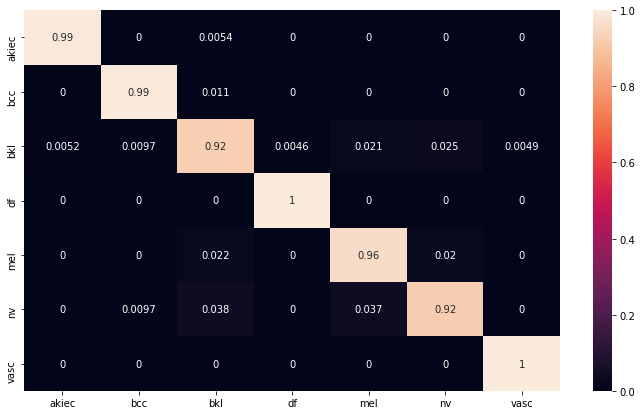

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []
# preds = []
# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs) # Feed Network
        
#         preds = torch.cat(outputs, dim=1)
#         preds.append(output)
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = le.classes_

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [30]:
from sklearn.metrics import classification_report

cr = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True))
cols = [i for i in classes] +['accuracy','macro avg','weighted avg']
cr.columns = cols
cr.T

,precision,recall,f1-score,support
akiec,0.994845,0.994845,0.994845,194.000000
bcc,0.980861,0.990338,0.985577,207.000000
bkl,0.924731,0.924731,0.924731,186.000000
df,0.995392,1.000000,0.997691,216.000000
mel,0.943005,0.957895,0.950392,190.000000
nv,0.953846,0.920792,0.937028,202.000000
vasc,0.995146,1.000000,0.997567,205.000000
accuracy,0.970714,0.970714,0.970714,0.970714
macro avg,0.969689,0.969800,0.969690,1400.000000
weighted avg,0.970640,0.970714,0.970622,1400.000000


In [33]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in list(range(0,7)):
    prec,recall,_,_ = precision_recall_fscore_support(np.array(y_true)==l,
                                                      np.array(y_pred)==l,
                                                      pos_label=True,average=None)
    res.append([categories[l],recall[0],recall[1]])

res = pd.DataFrame(res,columns = ['class','sensitivity','specificity'])
res

,class,sensitivity,specificity
0,akiec,0.999171,0.994845
1,bcc,0.996647,0.990338
2,bkl,0.988468,0.924731
3,df,0.999155,1.000000
4,mel,0.990909,0.957895
5,nv,0.992487,0.920792
6,vasc,0.999163,1.000000


In [29]:
# torch.save(model.state_dict() ,'C:\\Users\\saina\\Documents\\Assignements\\Dissertation\\Saved Models\\res18_trained_20best_sample.pt') 

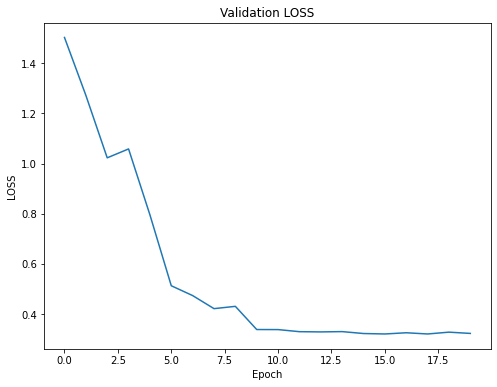

In [73]:
## loss graphs

metric = 'LOSS'
# Initialize a figure
fig = plt.figure(figsize=(8, 6))

# Plot values
plain_plt, = plt.plot(test_trackers['test_losses'])


# Set plot title
plt.title(f'Validation {metric}')

# Label axes
plt.xlabel('Epoch')
plt.ylabel(metric)

# Set legend
location = 'upper' if metric == 'Loss' else 'lower'

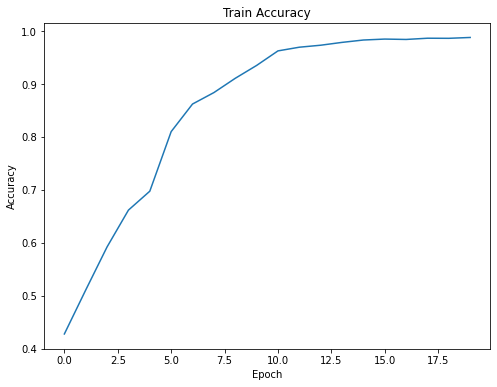

In [74]:
## train accuracy graphs

metric = 'Accuracy'
# Initialize a figure
fig = plt.figure(figsize=(8, 6))

# Plot values
plain_plt, = plt.plot(train_trackers['train_acc'])


# Set plot title
plt.title(f'Train {metric}')

# Label axes
plt.xlabel('Epoch')
plt.ylabel(metric)

# Set legend
location = 'upper' if metric == 'Loss' else 'lower'

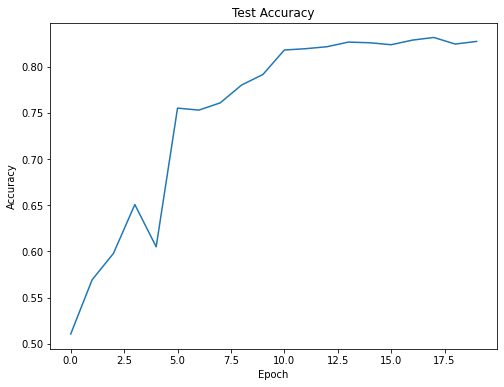

In [90]:
## test accuracy graphs

metric = 'Accuracy'
# Initialize a figure
fig = plt.figure(figsize=(8, 6))

# Plot values
plain_plt, = plt.plot(test_trackers['test_acc'])


# Set plot title
plt.title(f'Test {metric}')

# Label axes
plt.xlabel('Epoch')
plt.ylabel(metric)

# Set legend
location = 'upper' if metric == 'Loss' else 'lower'

In [27]:
model_path = 'C:\\Users\\saina\\Documents\\Assignements\\Dissertation\\Saved Models\\res18_trained_20best_sample.pt'

model = ResNet(BasicBlock, [2, 2, 2, 2],7 ,8).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

## GRADCAM

In [29]:
# list(model.children())

## GRAD CAM TEST DATA 

In [28]:
class CustomDataset2(torch.utils.data.Dataset):
    def __init__(self, data, transform = None):
        self.df = data
        self.transform = transform

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        image_path = self.df[['path']].iloc[index].item()
        image = np.asarray(pilimg.open(image_path).resize((64,64)))
        label = self.df[['class']].iloc[index].item()
        return image, label
    
test_dataset2 = CustomDataset2(test_met)

In [29]:
# from data import Transforms
from torchvision import datasets
sample_loader = torch.utils.data.DataLoader(test_dataset2, batch_size = 1, shuffle=True, num_workers=0, persistent_workers=False)

In [30]:
for image,label in sample_loader:
    break

C:\Users\saina\anaconda3\envs\eva\lib\site-packages\torch\utils\data\_utils\collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:205.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


In [31]:
image.shape, label

(torch.Size([1, 64, 64, 3]), tensor([6]))

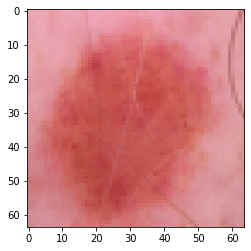

In [32]:
img1 = image[0]
plt.imshow(img1)

In [33]:
# img1 = np.transpose(image[0].squeeze().cpu().data.numpy(), (1,2,0))
# img1 = img1[...,::-1]
# plt.imshow( img1)

In [34]:
mean=(0.5, 0.5, 0.5)
std=(0.5, 0.5, 0.5)
transforms_list = [A.Normalize(mean=mean, std=std, always_apply=True),ToTensor()]

transform =  A.Compose(transforms_list)    

image = np.array(image)
image = transform(image=image)['image']
image = image.reshape(1,3,64,64)

In [35]:
list(model.children())[:-2]

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (shortcut): Sequential()
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (shortcut)

In [36]:
class ModelGradCam(nn.Module):
    
    def __init__(self, model):
        super().__init__()
        
        # get the pretrained resnet network
        self.res = model
        
        # disect the network to access its last convolutional layer
        self.features_conv = nn.Sequential(*list(self.res.children())[:-2])
        
        # # get the max pool of the features stem
        # self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the resnet
        self.classifier1 = list(self.res.children())[-2:][0]
        self.classifier2 = list(self.res.children())[-2:][1]

        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        # register the hook
        h = x.register_hook(self.activations_hook)
        # apply the remaining pooling
        x = self.classifier1(x)
        x = F.avg_pool2d(x, 8)
        x = x.view(x.size(0), -1)
        x = self.classifier2(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [37]:
def get_gradcamout(ModelGradCam, model, image):
    # initialize the resnet model
    res = ModelGradCam(model)
    # set the evaluation mode
    res.eval()
    # get the most likely prediction of the model
    pred = res(image)

    # get the gradient of the output with respect to the parameters of the model
    pred_idx = pred.argmax(dim=1)
    pred[:, pred_idx].backward()
    gradients = res.get_activations_gradient()
    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    # get the activations of the last convolutional layer
    activations = res.get_activations(image).detach()

    # weight the channels by corresponding gradients
    for i in range(256):
        activations[:, i, :, :] *= pooled_gradients[i]

    # weight the channels by corresponding gradients
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap.shape

    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap.cpu(), 0)
    heatmap.shape

    heatmap /= torch.max(heatmap)

    # normalize the heatmap
    # plt.matshow(heatmap.squeeze())

    heatmap_numpy_resized = cv2.resize(heatmap.cpu().data.numpy(), (600, 450))
    heatmap_rescaled = np.uint8(255 * heatmap_numpy_resized)

    # plt.imshow(heatmap_rescaled)
    return heatmap_rescaled

(100, 1000, 3)


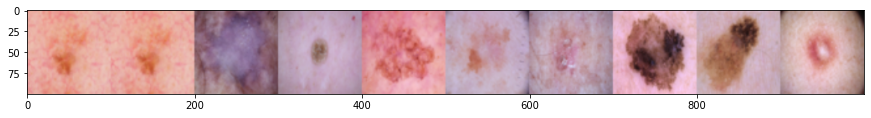

In [38]:
sample = {}
numpy_horizontal = []
limit = 0

grad_out = []

for image,label in sample_loader:
    limit+=1
    if limit==10:
        break
        
    image2 = image.reshape(64,64,3)
        
    mean=(0.5, 0.5, 0.5)
    std=(0.5, 0.5, 0.5)
    transforms_list = [A.Normalize(mean=mean, std=std, always_apply=True),ToTensor()]

    transform =  A.Compose(transforms_list)    

    image = np.array(image)
    image = transform(image=image)['image']
    image = image.reshape(1,3,64,64)
    hm = get_gradcamout(ModelGradCam, model, image)
        
    if len(grad_out)==0:
        grad_out = np.hstack((hm, hm))
    else:
        grad_out = np.hstack((grad_out, hm))    
    
    if len(numpy_horizontal)==0:
        numpy_horizontal = np.hstack((image2, image2))
    else:
        numpy_horizontal = np.hstack((numpy_horizontal, image2))

x = cv2.resize(numpy_horizontal,(1000, 100))
print(x.shape)
plt.figure(figsize=(15,8))
plt.imshow(x)

(100, 1000)


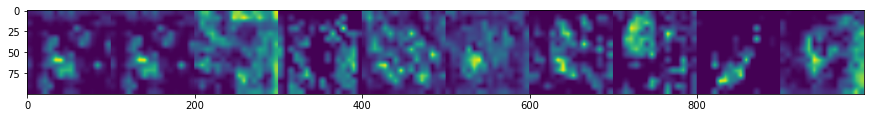

In [39]:
y = cv2.resize(grad_out,(1000, 100))
print(y.shape)
plt.figure(figsize=(15,8))
plt.imshow(y)

## CAPTUM

In [32]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [33]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [34]:
import timm
import urllib
import torch

import numpy as np

import torchvision.transforms as T
import torch.nn.functional as F

from PIL import Image

from matplotlib.colors import LinearSegmentedColormap

import matplotlib.pyplot as plt

In [35]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

categories = {v: k for k, v in le_name_mapping.items()}
categories

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}

In [36]:
for image_og,label in sample_loader:
    break

In [37]:
image_og.shape, label

(torch.Size([1, 64, 64, 3]), tensor([4]))

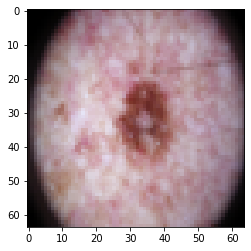

In [38]:
img1 = image_og[0]
plt.imshow(img1)

In [53]:
mean=(0.5, 0.5, 0.5)
std=(0.5, 0.5, 0.5)
transforms_list = [A.Normalize(mean=mean, std=std, always_apply=True),ToTensor()]

transform =  A.Compose(transforms_list)    

image = np.array(image_og)
image = transform(image=image)['image']
image = image.reshape(1,3,64,64)

In [54]:
model.eval()
output = model(image)
output = F.softmax(output, dim=1)

print('Output Probabilities : ' , output)

prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = categories[pred_label_idx.item()]
print('\n Predicted Class:', predicted_label, '| Probabilty  : ', prediction_score.squeeze().item())

Output Probabilities :  tensor([[1.5300e-04, 6.5403e-04, 4.2647e-03, 9.9397e-01, 4.4569e-05, 5.0398e-04,
         4.0990e-04]], grad_fn=<SoftmaxBackward0>)

 Predicted Class: df | Probabilty  :  0.9939699172973633


In [55]:
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(image, target=pred_label_idx, n_steps=200)

In [1]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(image.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

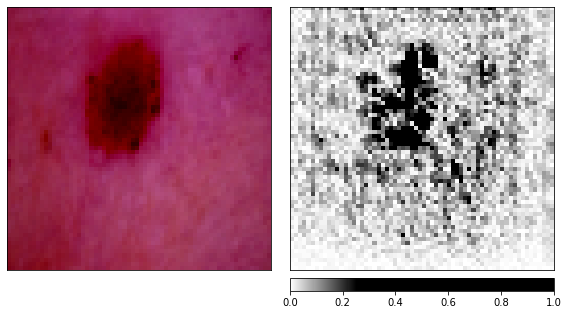

In [67]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
# Defining baseline distribution of images
rand_img_dist = torch.cat([image * 0, image * 1])

attributions_gs = gradient_shap.attribute(image,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(image.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [220]:
## Grad Cam

In [57]:
target_layers = [model.layer4[-1]] ## last but one layer

cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

targets = [ClassifierOutputTarget(6)]
# pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=image, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
rgb_img = image.cpu().squeeze().permute(1, 2, 0).detach().numpy()
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

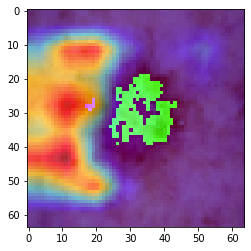

In [58]:
plt.imshow(visualization)

## UI

In [39]:
import gradio as gr
import cv2

In [40]:
def get_grad(model, image):
    target_layers = [model.layer4[-1]] ## last but one layer

    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

    targets = [ClassifierOutputTarget(6)]
    # pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=image, targets=targets)

    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    rgb_img = image.cpu().squeeze().permute(1, 2, 0).detach().numpy()
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    return visualization

def pre_process_input(inp):
    image = cv2.resize(inp,(64,64))
    print('Image Shape : ', image.shape)
    mean=(0.5, 0.5, 0.5)
    std=(0.5, 0.5, 0.5)
    transforms_list = [A.Normalize(mean=mean, std=std, always_apply=True),ToTensor()]
    transform =  A.Compose(transforms_list)    

    image = np.array(image)
    image = transform(image=image)['image']
    image = image.reshape(1,3,64,64)
    
    return image

def classify_image(inp):
    inp_p = pre_process_input(inp)
    
    prediction = model(inp_p).flatten()
    
    visualization = get_grad(model, inp_p)
    return {categories[i]: float(prediction[i])/10 for i in range(7)}, visualization

image = gr.inputs.Image(shape=(64, 64))
label = gr.outputs.Label(num_top_classes=3)

gr.Interface(fn=classify_image, inputs="image", outputs=[label, "image"] ,    
             title="Resnet",
    description="CNN to Clasify Skin Cancer Sample",).launch(share=True)

C:\Users\saina\anaconda3\envs\eva\lib\site-packages\gradio\inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\saina\anaconda3\envs\eva\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\saina\anaconda3\envs\eva\lib\site-packages\gradio\outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
C:\Users\saina\anaconda3\envs\eva\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://00bfc1cd5741195fbe.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Image Shape :  (64, 64, 3)
Image Shape :  (64, 64, 3)
